imports

In [2]:
# %% Imports -----------------------------------------------------------
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import KNNImputer

from statsmodels.stats.outliers_influence import variance_inflation_factor

import sys
sys.path.insert(0, "../src")   # keep original relative module path
import SCORE_functions as sf     # project‑specific helpers stay the same

load data

In [3]:
DATA_PATH = "../data/alldatatoML.xlsx"
OUTPUT_PATH_long = "../data/alldatatoML_preprocessed_long.xlsx"
OUTPUT_PATH_short = "../data/alldatatoML_preprocessed_short.xlsx"

dataset = pd.read_excel(DATA_PATH)

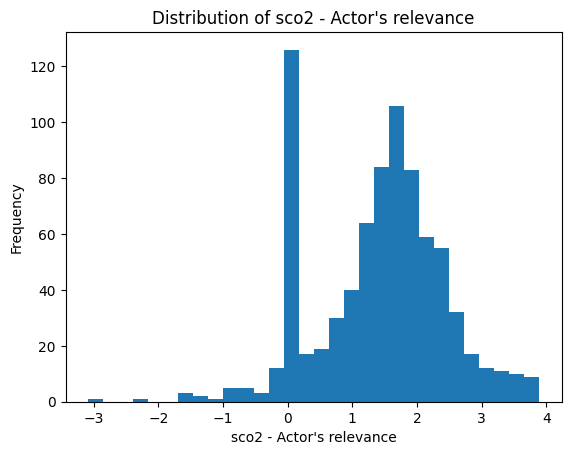

In [5]:
plt.hist(dataset["sco2 - Actor's relevance"], bins=30)
plt.xlabel("sco2 - Actor's relevance")
plt.ylabel('Frequency')
plt.title("Distribution of sco2 - Actor's relevance")
plt.show()

In [ ]:
# list of codes of inactive actors
inactive_codes = dataset.loc[dataset["cat - Legal status"] == "not active anymore", "Code"].tolist()
print(inactive_codes)

['MT02602', 'MT01602', 'MT03601', 'MT02604', 'MT03602', 'MT04201', 'MT04210', 'MT03619', 'MT03621', 'MT02828', 'MT01608', 'MT01611', 'MT03228', 'MT01616', 'MT00202', 'MT00217', 'MT00411', 'MT01623', 'MT02417', 'MT02427', 'MT02428', 'MT03423', 'MT01625', 'MT03004', 'MT03007', 'MT03020', 'MT02024', 'MT01230', 'MT00413', 'MT05026', 'MT03024', 'MT04408', 'MT04411', 'MT04419', 'MT04424', 'MT04423', 'MT04421', 'MT02013', 'MT03806', 'MT04204', 'MT04220', 'MT04211', 'MT04217', 'MT04218', 'MT04215', 'MT04221', 'MT04224', 'MT04229', 'MT03811', 'MT03813', 'MT03221', 'MT01003', 'MT01015', 'MT02423', 'MT03829', 'MT01207', 'MT00405', 'MT04003', 'MT05025', 'MT04219', 'MT03015', 'MT03022', 'MT02814', 'MT02822', 'MT03403', 'MT01810', 'MT01819', 'MT01820', 'MT01823', 'MT01826', 'MT01828', 'MT01232', 'MT01225', 'MT05222', 'MT01425', 'MT01423', 'MT03233', 'MT04807', 'MT04810', 'MT04821', 'MT03407', 'MT03010', 'MT04228', 'MT02014', 'MT00020', 'MT00021', 'MT00037', 'MT03412', 'MT03413', 'MT03409', 'MT00213'

In [9]:
dataset = dataset[dataset["cat - Legal status"] != "not active anymore"]

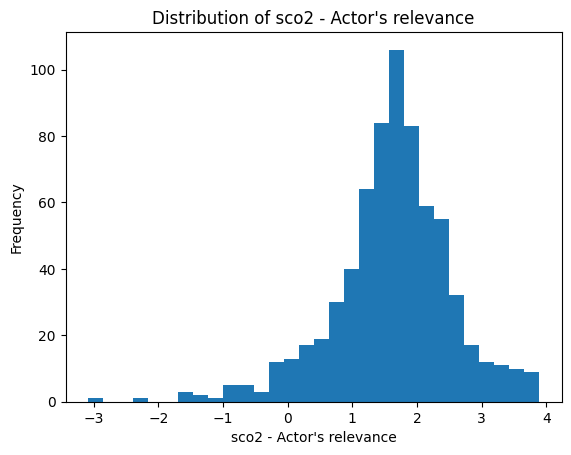

In [10]:
plt.hist(dataset["sco2 - Actor's relevance"], bins=30)
plt.xlabel("sco2 - Actor's relevance")
plt.ylabel('Frequency')
plt.title("Distribution of sco2 - Actor's relevance")
plt.show()

split data

In [69]:
sco1_cols = [c for c in dataset.columns if c.startswith("sco1 - ")]
sco2_cols = [c for c in dataset.columns if c.startswith("sco2 - ")]
cat_cols = [c for c in dataset.columns if c.startswith("cat - ")]

feature_cols = cat_cols + sco1_cols

X = dataset[feature_cols]
y = dataset[sco2_cols[-1]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)#, stratify=y)

imputation

In [70]:
X_train = X_train.copy()
X_test  = X_test.copy()

X_train.loc[:, "cat - Sector"] = X_train["cat - Sector"].fillna("no data available")
X_test .loc[:, "cat - Sector"] = X_test ["cat - Sector"].fillna("no data available")

tags_mode = X_train["cat - Tags"].mode().iat[0]
X_train.loc[:, "cat - Tags"] = X_train["cat - Tags"].fillna(tags_mode)
X_test .loc[:, "cat - Tags"] = X_test ["cat - Tags"].fillna(tags_mode)

for c in sco1_cols:
    X_train.loc[:, c] = X_train[c].fillna(X_train["sco1 - Actor's relevance"])
    X_test .loc[:, c] = X_test [c].fillna(X_test ["sco1 - Actor's relevance"])

X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162 entries, 697 to 516
Data columns (total 31 columns):
 #   Column                                                               Non-Null Count  Dtype  
---  ------                                                               --------------  -----  
 0   cat - Categories                                                     162 non-null    object 
 1   cat - Classes                                                        162 non-null    object 
 2   cat - Location of actor                                              162 non-null    object 
 3   cat - Geographic coverage                                            162 non-null    object 
 4   cat - Expertise                                                      162 non-null    object 
 5   cat - Sector                                                         162 non-null    object 
 6   cat - Tags                                                           162 non-null    object 
 7   cat - Legal

one hot encoding

In [71]:
cat_cols = [c for c in dataset.columns if c.startswith("cat - ")]

def ohe_multilabel(df, cols):
    """
    one-hot encode (handles comma-separated and single values)
    """
    dummies = []
    for c in cols:
        d = (df[c].fillna('')
                .astype(str)
                .str.get_dummies(sep=',')
                .rename(columns=lambda s: f"{c}__{s.strip()}"))
        dummies.append(d)
    return pd.concat([df.drop(columns=cols)] + dummies, axis=1)

X_train_ohe = ohe_multilabel(X_train, cat_cols)
X_test_ohe  = ohe_multilabel(X_test,  cat_cols).reindex(columns=X_train_ohe.columns, fill_value=0)

print("X_train_ohe shape is: ", X_train_ohe.shape)
print("more columns = ", X_train_ohe.shape[1]-X_train.shape[1])

X_train_ohe shape is:  (645, 181)
more columns =  150


scale (-4, 4) -> (-1,1)

In [72]:
X_train_clipped = X_train_ohe.clip(lower=-4, upper=4)
X_test_clipped  = X_test_ohe.clip(lower=-4, upper=4)

scaler = MinMaxScaler(feature_range=(-1, 1))
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_clipped), columns=X_train_ohe.columns, index=X_train_ohe.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_clipped), columns=X_test_ohe.columns, index=X_test_ohe.index)

remove cols low variance <= 0.01

In [73]:
vt = VarianceThreshold(threshold=0.01) #threshold=0.0 is removes less (only 2)
X_train_vt = pd.DataFrame(vt.fit_transform(X_train_scaled), columns=X_train_scaled.columns[vt.get_support()], index=X_train_scaled.index)
X_test_vt = pd.DataFrame(vt.transform(X_test_scaled), columns=X_train_vt.columns, index=X_test_scaled.index)

removed_cols = list(set(X_train_scaled.columns) - set(X_train_vt.columns))
print("removed cols = ", len(removed_cols),": ", removed_cols)

removed cols =  9 :  ['cat - Geographic coverage__Deir-ez-Zor - Al Mayadin', 'cat - Categories__Returnees', 'cat - Geographic coverage__Hama - Masyaf', 'cat - Geographic coverage__Quneitra - Al Fiq', 'cat - Geographic coverage__Rural Damascus - Az-Zabdani', 'cat - Legal status__In the process of acquiring a permit', 'cat - Categories__Host communities', "cat - Geographic coverage__Idleb - Al Ma'ra", 'cat - Geographic coverage__Al-Hasakeh - Ras Al Ain']


remove classes

multicolinearity vif <= 10 

In [74]:
def calc_vif(df: pd.DataFrame) -> pd.DataFrame:
    """Return dataframe of VIF values for each column."""
    vif = pd.DataFrame()
    vif["feature"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif

# Iteratively drop the worst offender until all VIF <= 10
vif_threshold = 10.0
X_train_vif = X_train_vt.copy()
while True:
    vif_df = calc_vif(X_train_vif)
    max_vif = vif_df["VIF"].max()
    if max_vif <= vif_threshold or X_train_vif.shape[1] < 2:
        break
    drop_col = vif_df.sort_values("VIF", ascending=False).iloc[0, 0]
    X_train_vif.drop(columns=[drop_col], inplace=True)

# Align test set to the same columns
X_test_vif = X_test_vt[X_train_vif.columns]

removed_cols = list(set(X_train_vt.columns) - set(X_train_vif.columns))
print("removed cols = ", len(removed_cols),": ", removed_cols)

c:\Users\ghiat\anaconda3\envs\score_env\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\ghiat\anaconda3\envs\score_env\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\ghiat\anaconda3\envs\score_env\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\ghiat\anaconda3\envs\score_env\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\ghiat\anaconda3\envs\score_env\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\ghiat\anaconda3\

removed cols =  93 :  ['cat - Categories__Tribes and families', "cat - Geographic coverage__Dar'a - Izra'", 'cat - Financial status__Not financed - financing stopped', 'cat - Geographic coverage__Tartous - Safita', 'sco1 - 4.2. Community accessibility to resources (Economy)', 'cat - Location of actor__As Suwayda', 'cat - Geographic coverage__As-Sweida - As-Sweida', 'cat - Location of actor__Qudsaya', 'cat - Categories__iNGOs', 'cat - Geographic coverage__Aleppo - Jarablus', 'cat - Legal status__the category doesn’t apply', 'sco1 - Economy, safety, and security', 'cat - Categories__Women groups', 'cat - Location of actor__Qamishli', 'cat - Categories__Local coordination groups', 'cat - Categories__Syndicates', 'cat - Location of actor__Salamiyah', 'sco1 - Formal and informal integration', 'cat - Location of actor__Tartous', 'cat - Geographic coverage__Lattakia - Lattakia', 'cat - Geographic coverage__Homs - Homs', 'cat - Location of actor__Al-Hasakeh', 'sco1 - Responsibility & accountab

reconcatinate and save:

with and without multicol because it kept 79 cols from 172 removing 93

In [75]:
train_complete = pd.concat([X_train_vif, y_train], axis=1)
train_complete["split"] = "train"

test_complete  = pd.concat([X_test_vif, y_test], axis=1)
test_complete["split"] = "test"

dataset_final = pd.concat([train_complete, test_complete])

dataset_final.to_excel(OUTPUT_PATH_short, index=False)
print(f"Preprocessing finished – file written to {OUTPUT_PATH_short}")

Preprocessing finished – file written to ../data/alldatatoML_preprocessed_short.xlsx


In [76]:
train_complete = pd.concat([X_train_vt, y_train], axis=1)
train_complete["split"] = "train"

test_complete  = pd.concat([X_test_vt, y_test], axis=1)
test_complete["split"] = "test"

dataset_final = pd.concat([train_complete, test_complete])

dataset_final.to_excel(OUTPUT_PATH_long, index=False)
print(f"Preprocessing finished – file written to {OUTPUT_PATH_long}")

Preprocessing finished – file written to ../data/alldatatoML_preprocessed_long.xlsx
